# Standardized Test Sheet Answer Scanner

In this code I implemented a standardized test sheet scanner to identify the filled-in answers and display the final grade for the answered sheet.



![alt text](https://drive.google.com/uc?id=1vGWhwRGMbrFTW1FG0kCH9i3n34Sxd4jy)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd /content/drive/MyDrive/CIS5810/extra_project

/content/drive/MyDrive/CIS5810/extra_project


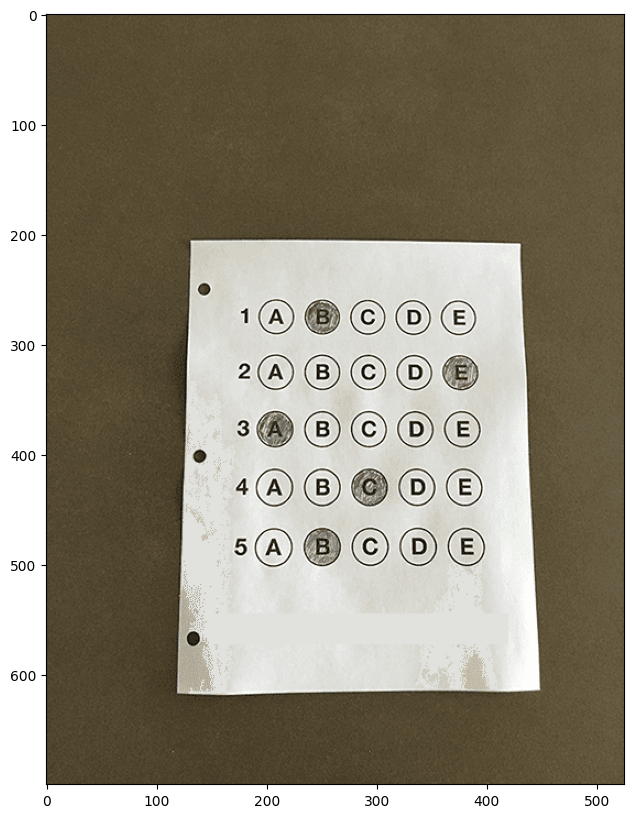

In [6]:
from imutils.perspective import four_point_transform
from imageutils import display
from imutils import contours
import numpy as np
import imutils
import cv2

image = cv2.imread("IM/test_sheet2.png")
display(image)

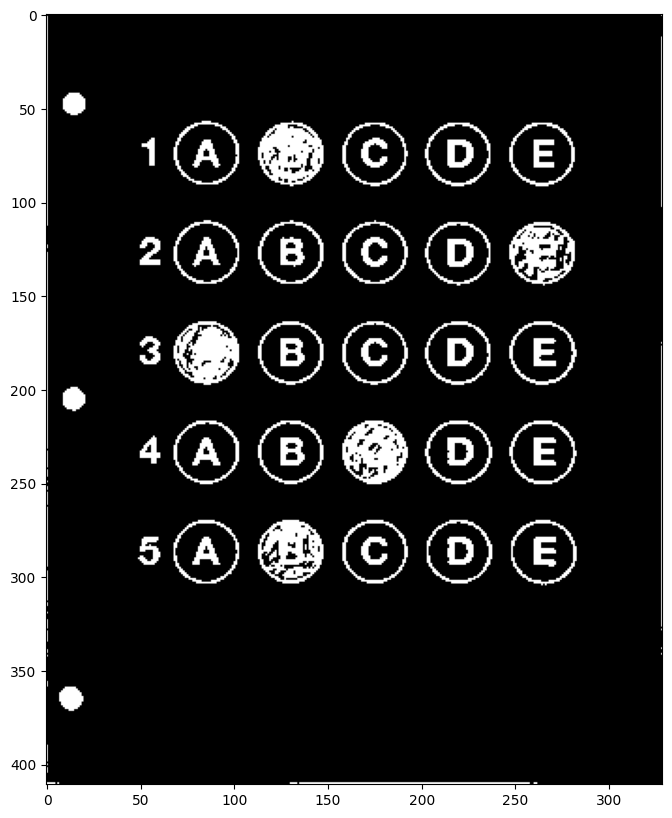

In [7]:
# define the answer key which maps the question number to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

# load the image, convert it to grayscale, blur it slightly, then find edges
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

# find contours in the edge map, then initialize the contour that corresponds to the sheet
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

# ensure that at least one contour was found
if len(cnts) > 0:
	# sort the contours according to their size in descending order
	cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

	# loop over the sorted contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)

		# if our approximated contour has four points, we can assume we have found the paper
		if len(approx) == 4:
			docCnt = approx
			break

# apply a four point perspective transform to both the original image and grayscale image
# obtain a top-down birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

# apply Otsu's thresholding method to binarize the warped piece of paper
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
display(thresh)

In [8]:
# find contours in the thresholded image
# initialize the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []

# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	# use the bounding box to derive the aspect ratio
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)

	# label the contour as a question
	# make the region sufficiently wide and tall with an aspect ratio approximately equal to 1
	if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
		questionCnts.append(c)

# sort the question contours top-to-bottom
# initialize the total number of correct answers
questionCnts = contours.sort_contours(questionCnts, method="top-to-bottom")[0]
correct = 0

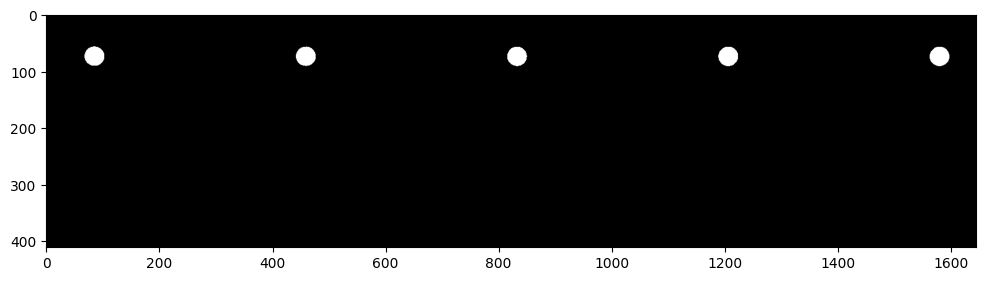

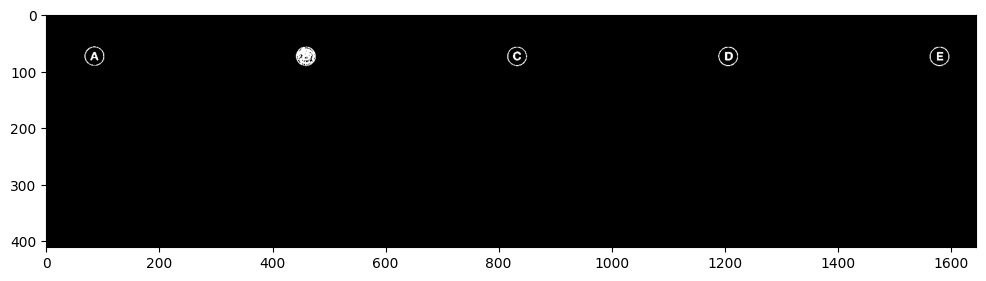

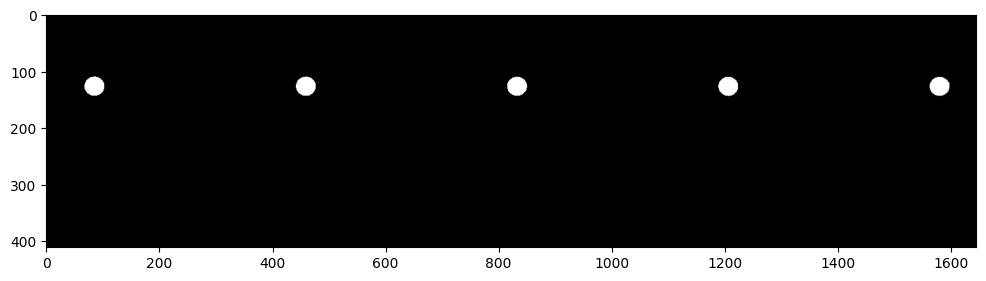

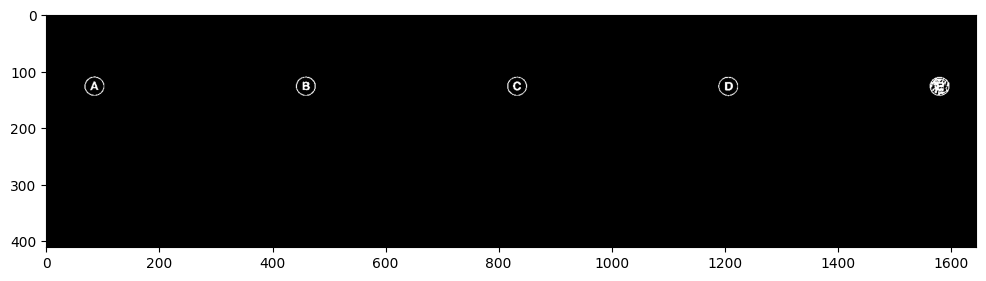

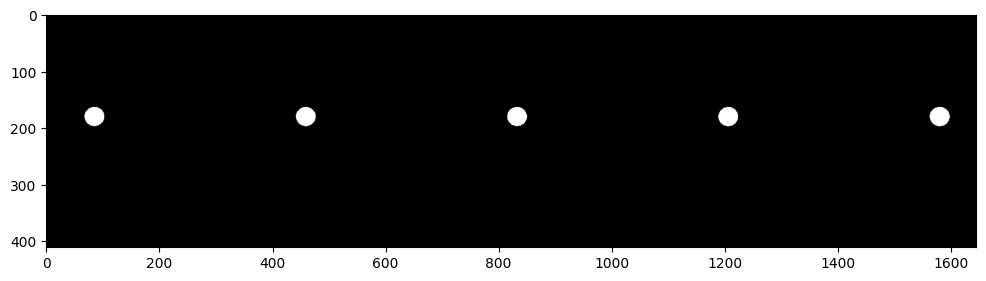

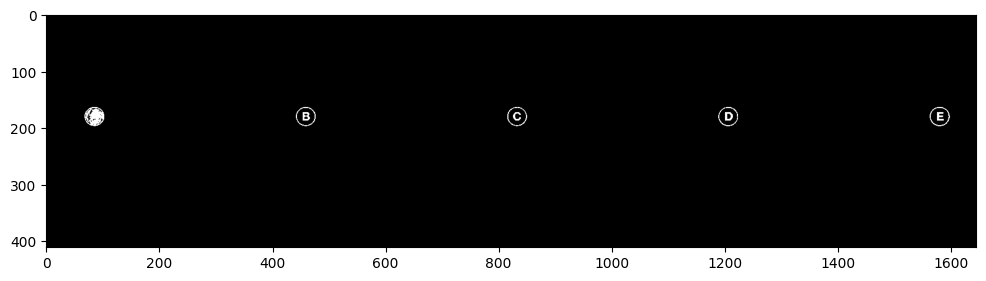

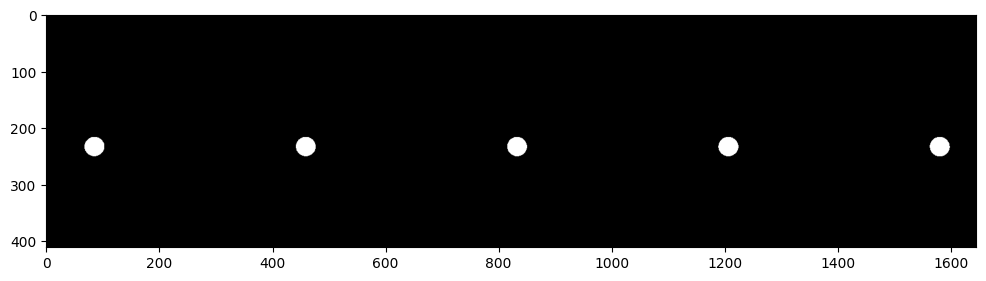

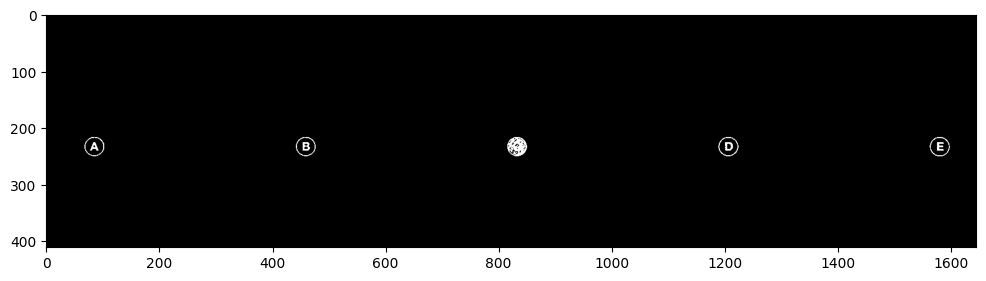

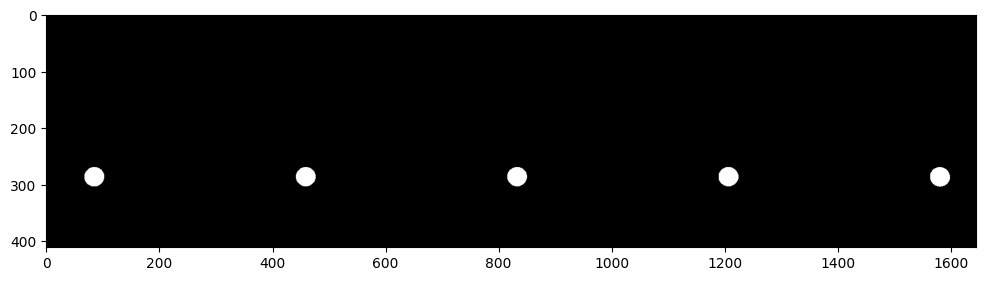

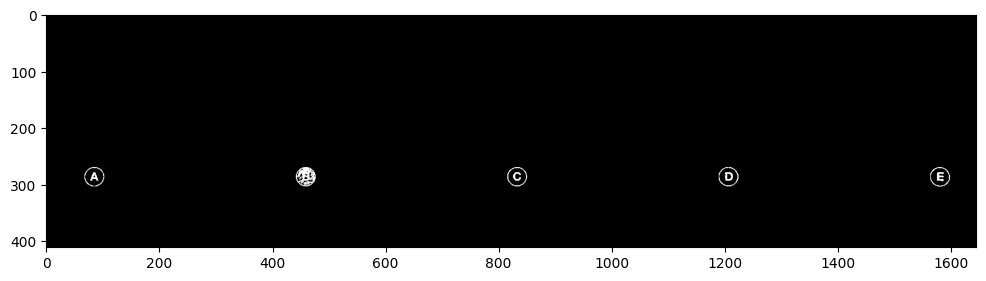

In [9]:
# each question has 5 possible answers to loop over the question in batches of 5
questions = np.arange(0, len(questionCnts), 5)

# Loop over the questions
for (q, i) in enumerate(questions):
	# sort the contours for the current question from left to right
	# initialize the index of the filled-in answer
	alternativesCnts = contours.sort_contours(questionCnts[i:i + 5])[0]
	bubbled = None
	montage = None
	montageBw = None

	# loop over the question alternatives
	for (j, c) in enumerate(alternativesCnts):
		# construct a mask that reveals only the current filled-in answer
		mask = np.zeros(thresh.shape, dtype="uint8")
		cv2.drawContours(mask, [c], -1, 255, -1)

		# apply the mask to the thresholded image
		# count the number of non-zero pixels in the area of filled-in answer
		maskBw = cv2.bitwise_and(thresh, thresh, mask=mask)
		total = cv2.countNonZero(maskBw)

		# merge images to better show it bellow with plt
		if montage is None:
			montage = mask
			montageBw = maskBw
		# otherwise, horizontally stack the images
		else:
			montage = np.hstack([montage, mask])
			montageBw = np.hstack([montageBw, maskBw])

		# if the current total has a larger number of total non-zero pixels,
		# then we are examining the currently filled-in answer
		if bubbled is None or total > bubbled[0]:
			bubbled = (total, j)

  # mask for the alternative box
	display(montage)

  # mask for the alternative box and letter
	display(montageBw)

  # initialize the contour color and the index of the correct answer
	color = (0, 0, 255)
	k = ANSWER_KEY[q]

  # check to see if the filled-in answer is correct
	if k == bubbled[1]:
		color = (0, 255, 0)
		correct += 1

	# draw the outline of the correct answer on the test
	cv2.drawContours(paper, [alternativesCnts[k]], -1, color, 3)


[INFO] score: 80.00%


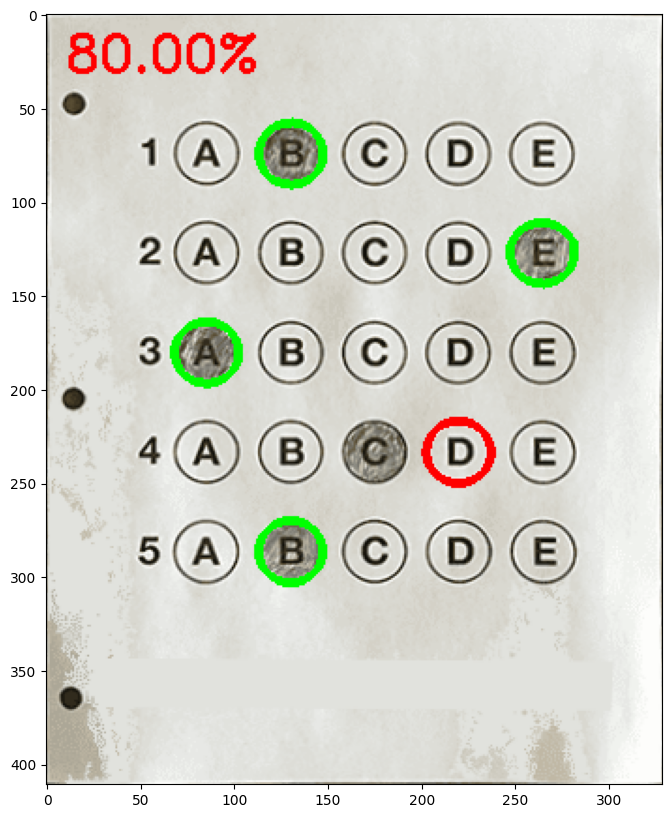

In [10]:
# calculate the final score and display it to the screen
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

display(paper)
